In [1]:
from pathlib import Path
import urllib, tarfile, os, zipfile, shutil
import pandas as pd
from fastai.vision import *
from fastai.widgets import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    tf = tarfile.open(fn)
    print('extracting', fn, '...')
    tf.extractall()

In [2]:
path = Path('images/')
path.ls()

[PosixPath('images/any_findings.pkl'),
 PosixPath('images/export.pkl'),
 PosixPath('images/train'),
 PosixPath('images/test'),
 PosixPath('images/models'),
 PosixPath('images/findings.pkl')]

In [13]:
path_train = path/'train'
path_train.mkdir()

['00017903_006.png',
 '00010308_005.png',
 '00028864_004.png',
 '00026747_001.png',
 '00027320_012.png']

In [33]:
train_val_txt = open('train_val_list.txt', 'r')
train_txt_split = train_val_txt.read().splitlines()
for fname in train_txt_split:
    shutil.move(path/fname, path_train/fname)

In [15]:
path_test = path/'test'
path_test.mkdir()

In [29]:
test_txt = open('test_list.txt', 'r')
test_txt_split = test_txt.read().splitlines()
for fname in test_txt_split:
    shutil.move(path/fname, path_test/fname)

In [28]:
df = pd.read_csv('Data_Entry_2017.csv')
df = df[['Image Index','Finding Labels']]
df.tail()

In [16]:
fnames_train = get_image_files(path_train)
fnames_train_str = [str(fname)[13:] for fname in fnames_train]; fnames_train_str[:5]

['00028246_000.png',
 '00015058_021.png',
 '00020213_014.png',
 '00007018_054.png',
 '00020429_028.png']

In [19]:
fnames_test = get_image_files(path_test)
fnames_test_str = [str(fname)[12:] for fname in fnames_test]; fnames_test_str[:5]

['00028246_000.png',
 '00015058_021.png',
 '00020213_014.png',
 '00007018_054.png',
 '00020429_028.png']

In [23]:
# todo: optimise bellow line since now it takes a few minutes
df_modified = df.replace(fnames_train_str, ['train/'+fname for fname in fnames_train_str])
df_modified.replace(fnames_test_str, ['test/'+fname for fname in fnames_test_str], inplace=True)
df_modified['is_valid'] = [True if 'test' in x else False for x in df_modified['Image Index']]
df_modified.head()

,Image Index,Finding Labels
0,train/00000001_000.png,Cardiomegaly
1,train/00000001_001.png,Cardiomegaly|Emphysema
2,train/00000001_002.png,Cardiomegaly|Effusion
3,train/00000002_000.png,No Finding
4,00000003_000.png,Hernia


In [19]:
df_modified.to_csv('Data_Entry_2017_modified.csv', index=False)

In [3]:
df_modified = pd.read_csv('Data_Entry_2017_modified.csv')
df_modified.head()

,Image Index,Finding Labels,is_valid
0,train/00000001_000.png,Cardiomegaly,False
1,train/00000001_001.png,Cardiomegaly|Emphysema,False
2,train/00000001_002.png,Cardiomegaly|Effusion,False
3,train/00000002_000.png,No Finding,False
4,test/00000003_000.png,Hernia,True


In [4]:
df_modified['Finding Labels'].replace('^(?!No\sFinding).*$', 'Finding', regex=True, inplace=True)
df_modified.head()

,Image Index,Finding Labels,is_valid
0,train/00000001_000.png,Finding,False
1,train/00000001_001.png,Finding,False
2,train/00000001_002.png,Finding,False
3,train/00000002_000.png,No Finding,False
4,test/00000003_000.png,Finding,True


In [ ]:
df_modified.to_csv('Data_Entry_2017_any_findings.csv', index=False)

# Training model to recognize whether there is any anomaly

In [3]:
df_any_findings = pd.read_csv('Data_Entry_2017_any_findings.csv')

In [15]:
seriesObj = df_any_findings.apply(lambda x: True if 'No Finding' in x['Finding Labels'] else False , axis=1)
 
# Count number of True in series
numOfRows = len(seriesObj[seriesObj == False].index); numOfRows

51759

In [19]:
bs=64
np.random.seed(42)
src = (ImageList.from_df(df=df_any_findings, path=path)
       .split_from_df()
       .label_from_df())

In [20]:
tfms = get_transforms(flip_vert=False, max_warp=0.)

In [21]:
data = (src.transform(tfms, size=224)
        .databunch(bs=bs).normalize(imagenet_stats))

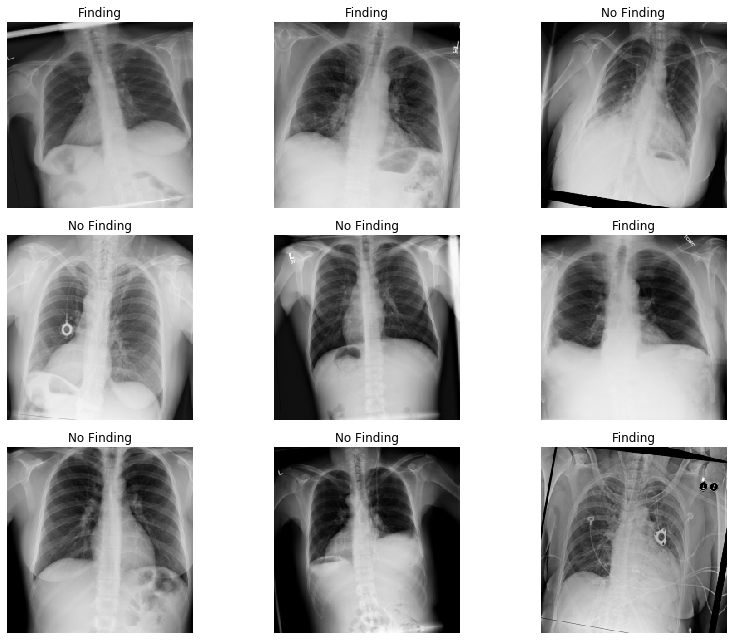

In [22]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
data.classes

['Finding', 'No Finding']

In [30]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, AUROC()], wd=1e-1).to_fp16()
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


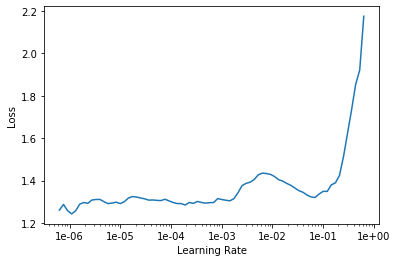

In [31]:
learn.lr_find()
learn.recorder.plot()

In [43]:
lr = 0.03

In [32]:
learn.fit_one_cycle(4, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.612127,0.604663,0.308837,0.697361,19:21
1,0.582859,0.607965,0.304930,0.705357,14:55
2,0.567903,0.591967,0.291022,0.720606,14:57
3,0.555679,0.589062,0.291139,0.720630,14:57


In [33]:
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.551104,0.585811,0.289108,0.724417,14:56


In [34]:
learn.save('any-findings-stage-1-rn50-bs64-wd-fp16')

In [15]:
learn.load('stage-1-rn34-bs64-wd')

Learner(data=ImageDataBunch;

Train: LabelList (86524 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Finding,Finding,Finding,No Finding,Finding
Path: images;

Valid: LabelList (25596 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Finding,Finding,Finding,Finding,Finding
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [35]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


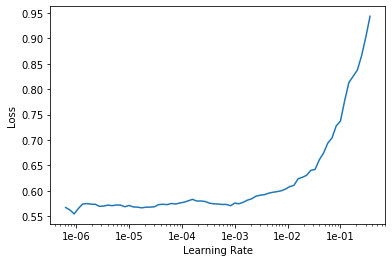

In [36]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(4, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.595294,0.601759,0.302235,0.706093,13:45
1,0.578232,0.601471,0.309658,0.714284,13:56
2,0.576934,0.591267,0.293093,0.716473,14:01
3,0.574891,0.590145,0.291530,0.717320,14:03


In [50]:
learn.save('stage-2-rn34-bs64-wd')

# Training model to recognize anomalies

In [3]:
df_findings=pd.read_csv('Data_Entry_2017_modified.csv')
df_findings.drop(df_findings[df_findings['Finding Labels'] == 'No Finding'].index, inplace=True)
df_findings.to_csv('Data_Entry_2017_findings.csv', index=False)
df_findings.shape


(51759, 3)

In [3]:
df_findings=pd.read_csv('Data_Entry_2017_findings.csv')
df_findings.head()

,Image Index,Finding Labels,is_valid
0,train/00000001_000.png,Cardiomegaly,False
1,train/00000001_001.png,Cardiomegaly|Emphysema,False
2,train/00000001_002.png,Cardiomegaly|Effusion,False
3,test/00000003_000.png,Hernia,True
4,test/00000003_001.png,Hernia,True


In [4]:
bs=64
np.random.seed(42)
src = (ImageList.from_df(df=df_findings, path=path)
       .split_from_df()
       .label_from_df(label_delim='|'))

In [5]:
tfms = get_transforms(flip_vert=False, max_warp=0.)

In [8]:
data = (src.transform(tfms, size=224)
        .databunch(bs=bs).normalize(imagenet_stats))
data.classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [7]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
acc_03 = partial(accuracy_thresh, thresh=0.3)
f_1_score = partial(fbeta, thresh=0.5, beta=1)
f_2_score = partial(fbeta, thresh=0.5, beta=2)

learn = cnn_learner(data, models.resnet50, metrics=[acc_02, acc_03, f_1_score, f_2_score])

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


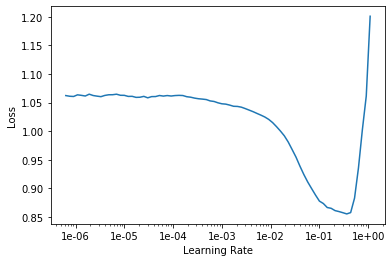

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
lr = 1e-2

In [10]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.290182,0.319998,0.821195,0.853071,0.210411,0.194924,09:26
1,0.262348,0.294271,0.830637,0.865877,0.207090,0.190125,06:34
2,0.249795,0.287425,0.840551,0.870966,0.245230,0.225817,06:37
3,0.244268,0.283448,0.839007,0.871878,0.284098,0.263495,06:44


In [22]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.255713,0.285271,0.822457,0.864992,0.316195,0.296910,06:42
1,0.242260,0.280522,0.840528,0.873240,0.293360,0.272365,06:47


In [23]:
learn.save('findings-stage-1-rn50-bs64')

In [34]:
learn.load('findings-stage-1-rn50-bs64')

Learner(data=ImageDataBunch;

Train: LabelList (36024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
Cardiomegaly,Cardiomegaly;Emphysema,Cardiomegaly;Effusion,Mass;Nodule,Infiltration
Path: images;

Valid: LabelList (15735 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
Hernia,Hernia,Hernia,Hernia;Infiltration,Hernia
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


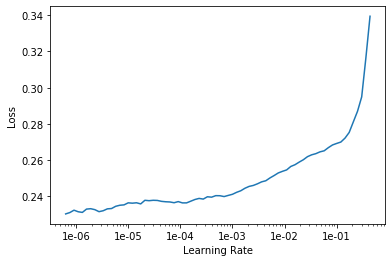

In [25]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(4, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.240778,0.279846,0.839575,0.873685,0.300444,0.278917,06:21
1,0.238453,0.280524,0.844237,0.874043,0.296325,0.274481,06:25
2,0.236730,0.279646,0.840860,0.873208,0.307910,0.286143,06:26
3,0.235366,0.279189,0.838831,0.872400,0.314716,0.293011,06:25


In [37]:
learn.fit_one_cycle(2, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.237020,0.279400,0.839139,0.872840,0.318262,0.296217,06:23
1,0.238706,0.279230,0.839207,0.872650,0.314547,0.292841,06:23


In [38]:
learn.save('findings-stage-2-rn50-bs64')

In [8]:
learn.load('findings-stage-2-rn50-bs64')

Learner(data=ImageDataBunch;

Train: LabelList (36024 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: MultiCategoryList
Cardiomegaly,Cardiomegaly;Emphysema,Cardiomegaly;Effusion,Mass;Nodule,Infiltration
Path: images;

Valid: LabelList (15735 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: MultiCategoryList
Hernia,Hernia,Hernia,Hernia;Infiltration,Hernia
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Batch

# Experimenting with progressive resizing

In [14]:
learn.load('stage-3-rn50-bs64')

Learner(data=ImageDataBunch;

Train: LabelList (86524 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: MultiCategoryList
Cardiomegaly,Cardiomegaly;Emphysema,Cardiomegaly;Effusion,No Finding,Mass;Nodule
Path: images;

Valid: LabelList (25596 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: MultiCategoryList
Hernia,Hernia,Hernia,Hernia;Infiltration,Hernia
Path: images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNo

In [6]:
data = (src.transform(tfms, size=448)
        .databunch(bs=bs).normalize(imagenet_stats))

In [9]:
data.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [18]:
learn.data = data

In [12]:
learn.freeze()

In [10]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 14.73 GiB total capacity; 13.65 GiB already allocated; 269.88 MiB free; 13.75 GiB reserved in total by PyTorch)

In [26]:
lr = 1e-2

In [27]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.165447,0.254291,0.875202,0.894481,0.342096,34:49
1,0.166061,0.236470,0.861866,0.895390,0.276755,33:23
2,0.159427,0.229401,0.880150,0.901464,0.268553,33:14
3,0.158698,0.224863,0.869318,0.899349,0.296193,31:22


In [29]:
learn.save('stage-3-448-rn50-bs64-b4-unfreeze')

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


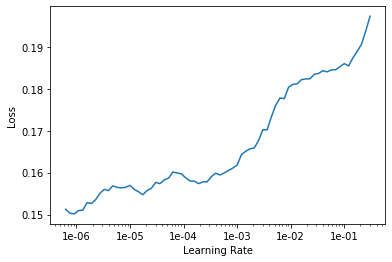

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(2, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.159975,0.227124,0.869808,0.898536,0.299756,34:18
1,0.154347,0.222796,0.867841,0.898851,0.297134,34:26


In [36]:
learn.fit_one_cycle(2, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,time
0,0.156097,0.224525,0.872113,0.898700,0.274944,34:29
1,0.153836,0.221143,0.866739,0.897872,0.301263,35:25


In [15]:
learn.save('stage-3-448-rn50-bs64-after-unfreeze-4es')

# Exporting for production

In [16]:
learn = learn.to_fp32()
learn.export('any_findings.pkl')

In [24]:
learn.export('findings.pkl')